# PyTorch Workflow
Resource for reading: https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
import torch
from torch import nn # contains all of PyTorch's building blocks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1'

### Data - preparing and loading
Data can be almost anything (spreadsheets, images, videos, audio, DNA, text, etc.)
MAchine learning is a game of two parts:
1. Get data into numerical representations
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using the linear regression formula. We will use a linear regression formula to make a straight line with *known* **parameters**.


In [2]:
# Create known parameters (y = a + bx, a = bias and b = weight)
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # adds extra dimension (needed when using models)
y = bias + weight * X


### Splitting data into training, (validation) and test sets 
(one of the most important concepts, often 80-20 percentage wise).

When more complex data use `sklearn.model_selection.train_test_split`

Resource: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualizing

In [4]:
# Create helper function to plot stuff
def plot_predictions(train_data=X_train,
                   train_labels=y_train,
                   test_data=X_test,
                   test_labels=y_test,
                   predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    # Set figure size 
    plt.figure(figsize=(10, 7))
    
    #Plot training data (blue)
    plt.scatter(train_data, train_labels, c="b", marker="o", s=10, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", marker="*", s=14, label="Testing data")
    
    # Are there predictions?
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", marker="+", s=14, label="Predictions")
        
    plt.legend(prop={"size": 14});
        

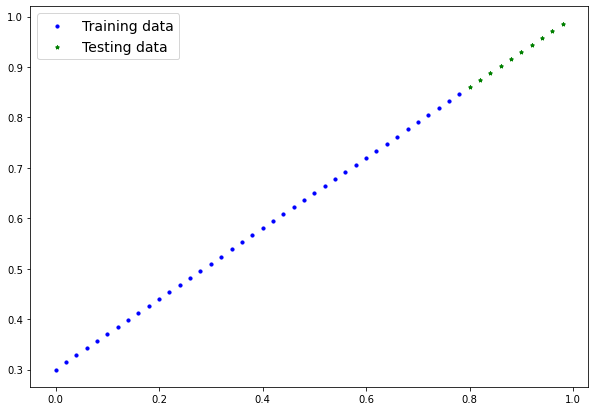

In [5]:
plot_predictions();

### Building a model for linear regression
Some explanations:
- `requres_grad=True` (is default) and means we keep track of gradients for specific parameter and updates them as we build our model
- subclass `nn-Module` contains all the building blocks for NNs
- in the contructor we initialize the weights and biases and in future applications it is here initialize layers from `torch.nn` or other functions
- the `forward()`-method should always be overwritten and is what defines the computations performed at every call (in this case a linear regression computation)

In [6]:
# Create linear regression model class (inherets from base class nn.Module)
# nn.Module has a lot of usefull in-built functionality 
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
    
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

What we are doing:
- starting with random values/parameters (weights & bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weights & bias values we used to create the data)

We do this with two main algorithms:
- gradient descent (https://www.youtube.com/watch?v=IHZwWFHWa-w)
- backpropagation (https://www.youtube.com/watch?v=Ilg3gGewQ5U)


### PyTorch model building essentials
- `torch.nn` - contains all of the building blocks for computational graphs (a NN can be considered a computational graph
- `torch.nn.Parameters` - what parameters should our model try to learn, often a PyTorch layer from torch.nn will set these for us
- `torch.nn.Module` - the base class for all NN modules, if you subclass it you should overwrite forward()-method
- `torch.optim` - this is where the optimizers in PyTorch live, will help with gradient descent
- `def forward()` - all nn.Module subclasses require you to overwrite forward()-method
- `torch.utils.data.Dataset` - represents a map between label and feature pairs of your data e. g. images with their associated label
- `torch.utils.data.DataLoader` - creates a `Python` iterable over torch `Dataset` (allows you to iterate over your data)
- `torchvision.transorms` - ...
- `torchvision.models` - ...
- `torchmetrics` - ...
- `torch.utils.tensorboard` - ...

### Create instance of our `LinearRegressionModel()`

In [7]:
# Checking contents of our PyTorch model

# Create random seed (without it our model would give us different
# parameters everytime we created our model)
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

# Create instance of our model (subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out parameters
list(model_0.parameters())

# List named parameters (the ideal values is what we defined above, 
# but are of course not known in real life)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Making predictions using `torch.inference_mode()`

That is: check our models predictive power. 
When we pass data through our model it is going to run it through the `forward()`-method. Inference mode turns of gradient tracking and therefore we don't know how we should update parameters. With large datasets our predictions will therefore become faster (we don't need them when making predictions). 

In [8]:
# Make predictions with our random model (they won't be good...)
with torch.inference_mode():
    y_preds = model_0(X_test)

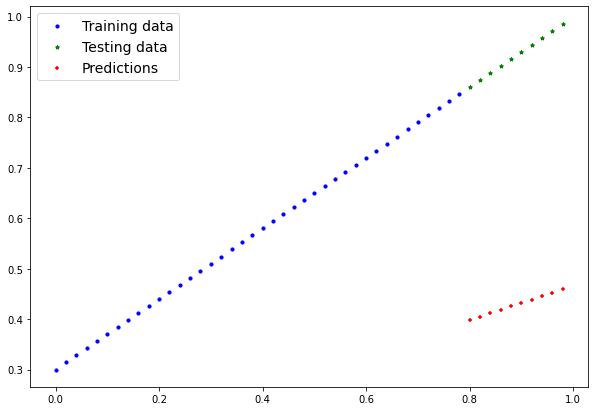

In [9]:
plot_predictions(predictions=y_preds)

#### Training our model 
*(set up loss function, optimizer and build training loop)*

The whole idea of training is to tune some *unkown* parameters from being a poor representation of the data to a better representation of the data. Measuring the wrongness of our model is done by using a loss/cost function. We want to minimize the loss function. There are different in-built loss-functions in `torch.nn`. In order to adjust the model's parameters (weights and bias) with respect to the loss/error function we need an opitimizer. 

Specifically for `PyTorch` we need:

A training loop:

0. Loop through data
1. Forward pass to make predictions
2. Calculate the loss and compare to forward pass predictions to ground truth labels
3. Optimizer zero grad
4. Loss backward (moves backward through the network to calculate the gradients of each of the parameters of our models with respect to loss)
5. Optimizer step (use optimizer to adjust our model's paramters to imporve the loss)



In [10]:
# Check out our model's parameters 
# (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
# Set up a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (optimizing-algorithm)
optimizer = torch.optim.SGD(params=model_0.parameters(), # stochastic gradient descent
                            lr=0.01)                     # learning rate (hyper parameter progammer sets)
torch.manual_seed(42)

# Set up training and testing loop
# An epoch (hyper parameter) is one forward pass through the network
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

## Training loop

# 0. Loop through data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # sets all parameters that require gradients to require gradients
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    # 3. Optimizer zero grad
    optimizer.zero_grad() # for some reason the gradients get accumulated?
    
    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer will accumulate through the loop so... 
                     # we have to zero them above in step 3 for the next iteation of the loop
    
    
    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout, batchNorm layers
    with torch.inference_mode(): # turns off gradient tracking + some other things -> more efficient
        # 1. Forward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate the test-loss
        test_loss = loss_fn(test_pred, y_test)
    
    # Print what is happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        # Print state
        print(model_0.state_dict())



Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [12]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)


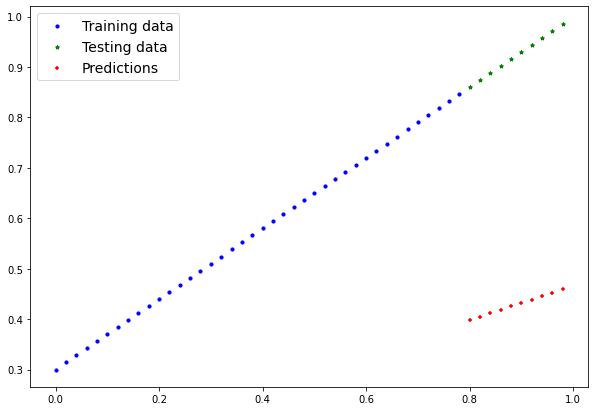

In [13]:
plot_predictions(predictions=y_preds)

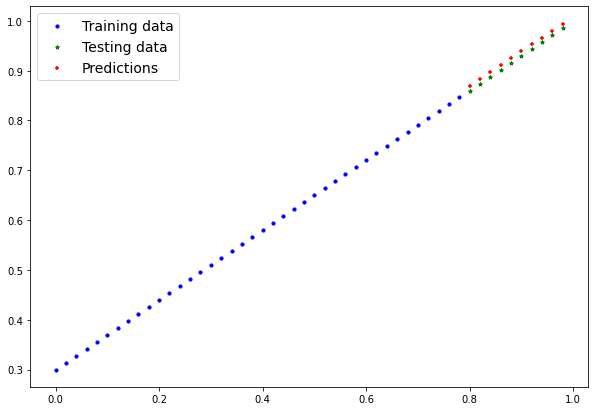

In [14]:
plot_predictions(predictions=y_preds_new)

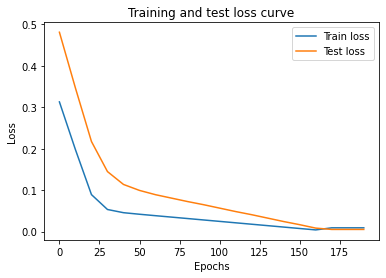

In [15]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

#### Saving a model in `PyTorch`:
There are 3 main methods for saving and loading models:
1. `torch.save()` - allows you to save a `PyTorch` object in `Python's` `pickle` format
2. `torch.load()` - allows you to load a saved `PyTorch` object
3. `torch.nn.Module.load_state_dict()` - allows you to load a model's saved dictionary

What is a `state_dict`?

In `PyTorch`, the learnable parameters (i.e. weights and biases) of a `torch.nn.Module` model are contained in the model’s parameters (accessed with `model.parameters()`). A state_dict is simply a `Python` dictionary object that maps each layer to its parameter tensor.